# Mnist DataScience (Training Stage)

****DataScienceTeam****: Responsible for training the machine learning model by using workflows
- *Steps*
    1. Import Scanflow and check the local environment
    2. Develop scanflow application (workflows)
    3. Build scanflow application
    4. Deploy scanflow environment
    5. ****[Training]****
         1. **Deploy scanflow workflows** (Argo)
         2. **Delete scanflow workflows** (Argo)
    **(step2-step5 can be repeated serveral times in order to get the final model)**
    6. Submit the metadata, models and artifacts to the central Scanflow-tracker
    7. Clean environment
- *Deliverables*
    1. Built scanflow application metadata
    2. Machine learning models
    3. DataScienceTeam artifacts

## Steps
### Step1: Import Scanflow and check the local environment
1. import scanflow
    - For defining and building scanflow application, we need to import ScanflowClient
    - For deploying scanflow application, we need to import ScanflowDeployerClient
    - For saving artifacts, we need to import ScanflowTrackerClient
2. check local environment
    - For deploying scanflow application
        - If user starts the notebook at local and has the privilege to submit object on Kubernetes. We don't need to configure "SCANFLOW_SERVER_URI"
        - If user starts the notebook inside Kubernetes pod, or the local user does not have privilege to connect Kubernetes. We need to configure "SCANFLOW_SERVER_URI"
    - For saving deliverables, we need to configure url of Scanflow-tracker on "SCANFLOW_TRACKER_URI" and url of Scanflow-local-tracker on "SCANFLOW_TRACKER_LOCAL_URI"
    - If Scanflow-tracker is using S3 artifact storage, we need to configure S3 url "MLFLOW_S3_ENDPOINT_URL", username "AWS_ACCESS_KEY_ID" and password "AWS_SECRET_ACCESS_KEY"

In [1]:
import sys
import os
sys.path.insert(0,'../..')

import scanflow
from scanflow.client import ScanflowClient
from scanflow.client import ScanflowTrackerClient
from scanflow.client import ScanflowDeployerClient

In [2]:
from scanflow.tools import env
print(env.get_env("SCANFLOW_SERVER_URI"))
print(env.get_env("SCANFLOW_TRACKER_URI"))
#print(env.get_env("SCANFLOW_TRACKER_LOCAL_URI"))
print(env.get_env("MLFLOW_S3_ENDPOINT_URL"))
print(env.get_env("AWS_ACCESS_KEY_ID"))
print(env.get_env("AWS_SECRET_ACCESS_KEY"))

http://84.88.189.179:32767
http://84.88.189.179:32766
http://84.88.189.179:32645
scanflow
scanflow123


### Step2: Develop scanflow application

  1. develop component (requirement.txt, script.py)
  2. define scanflow application (Executor, Dependency, Workflow, Application)
  ```bash
     Application
        - List: Workflow(DAG)
                  - List: Executor
                  - List: Dependency
  ```
  
     For example:
     
  ```bash
  mnist
    - workflows
       - load_data
         - loaddata.py
       - modeling_cnn1
         - modeling.py
         - req_modeling.txt
       - modeling_cnn2
         - modeling.py
         - req_modeling.txt
       - checker
         - checker.py
         - req_checker.txt
```


In [3]:
# App folder
scanflow_path = "/home/rocky/k8s_resources/scanflow"
app_dir = os.path.join(scanflow_path, "examples/mnist/datascience")
app_name = "mnist"
team_name = "datascience"

# scanflow client
client = ScanflowClient(
             #if you defined "SCANFLOW_SERVER_URI", you dont need to provide this
             #scanflow_server_uri="http://172.30.0.50:46666",
             verbose=True)

In [4]:
executor1 = client.ScanflowExecutor(name='load-data', 
                      mainfile='loaddata.py',
                      parameters={'app_name': app_name,
                                  'team_name': 'data'})

executor2 = client.ScanflowExecutor(name='modeling-cnn1', 
                      mainfile='modeling.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'epochs': 1,
                                  'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 
                                  'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy',
                                  'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy',
                                  'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'},
                      requirements='req_modeling.txt')

#20
executor3 = client.ScanflowExecutor(name='modeling-cnn2', 
                      mainfile='modeling.py',
                      parameters={'model_name': 'mnist_cnn',
                                  'epochs': 2,
                                  'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy',
                                  'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy',
                                  'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy',
                                  'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'},
                      requirements='req_modeling.txt',
                      base_image='modeling-cnn1')

# executor4 = client.ScanflowExecutor(name='modeling-tf', 
#                       mainfile='mnist_main_mlflow.py',
#                       parameters={'model_dir': '/tmp/model',
#                                   'data_dir': '/tmp/data',
#                                   'train_epochs': 10,
#                                   'distribution_strategy': 'one_device',
#                                   'num_gpus': 0},
#                       env={'PYTHONPATH':':/models'},
#                       base_image='modelgarden')


#50
executor5 = client.ScanflowExecutor(name='checker', 
                      mainfile='checker.py',
                      parameters={'model_name': 'mnist_detector',
                                  'epochs': 1,
                                  'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy'},
                      requirements='req_checker.txt')



dependency1 = client.ScanflowDependency(dependee='load-data',
                                    depender='modeling-cnn1')

dependency2 = client.ScanflowDependency(dependee='load-data',
                                    depender='modeling-cnn2')

# dependency3 = client.ScanflowDependency(dependee='load-data',
#                                     depender='modeling-tf')

dependency4 = client.ScanflowDependency(dependee='load-data',
                                    depender='checker')

##workflow1 mnist-wf
## -- load_data
##       -- modeling_cnn
##       -- modeling_cnn1
##       -- modeling_tf
workflow1 = client.ScanflowWorkflow(name='mnist-wf', 
                     nodes=[executor1, executor2, executor3],
                     edges=[dependency1, dependency2],
                     type = "batch",
                     output_dir = "/workflow")
##workflow2 mnist-checker-wf
## -- load_data
##    -- checker
workflow2 = client.ScanflowWorkflow(name='mnist-checker-wf', 
                     nodes=[executor1, executor5],
                     edges=[dependency4],
                     type = "batch",
                     output_dir = "/workflow")


app = client.ScanflowApplication(app_name = app_name,
                                 app_dir = app_dir,
                                 team_name = team_name,
                                 workflows=[workflow1, workflow2])
              

In [5]:
dic = app.to_dict()
dic

23-Jan-24 12:49:13 -  INFO - workflow mnist-wf: {'name': 'mnist-wf', 'nodes': [{'name': 'load-data', 'node_type': 'executor', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': None, 'timeout': None, 'resources': None, 'affinity': None}, {'name': 'modeling-cnn1', 'node_type': 'executor', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': None, 'timeout': None, 'resources': None, 'affinity': None}, {'name': 'modeling-cnn2', 'node_type': 'executor', 'mainfile': 

{'app_name': 'mnist',
 'app_dir': '/home/rocky/k8s_resources/scanflow/examples/mnist/datascience',
 'team_name': 'datascience',
 'workflows': [{'name': 'mnist-wf',
   'nodes': [{'name': 'load-data',
     'node_type': 'executor',
     'mainfile': 'loaddata.py',
     'parameters': {'app_name': 'mnist', 'team_name': 'data'},
     'requirements': None,
     'dockerfile': None,
     'base_image': None,
     'env': None,
     'image': None,
     'timeout': None,
     'resources': None,
     'affinity': None},
    {'name': 'modeling-cnn1',
     'node_type': 'executor',
     'mainfile': 'modeling.py',
     'parameters': {'model_name': 'mnist_cnn',
      'epochs': 1,
      'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy',
      'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy',
      'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy',
      'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'},
     'requirements':

  
### Step3: Build scanflow application (local)
   
  1. build images for Executor -> save to image registry
  
  - TODO:
     now scanflow only support local build with docker, in the future we will consider incluster build


In [6]:
build_app = client.build_ScanflowApplication(app = app, trackerPort=31000)

23-Jan-24 12:49:13 -  INFO - Building image registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/load-data
23-Jan-24 12:49:13 -  INFO - [+] Image [registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/load-data] has been found in repository. registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/load-data:latest.
23-Jan-24 12:49:13 -  INFO - Building image registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/modeling-cnn1
23-Jan-24 12:49:13 -  INFO - [+] Image [registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/modeling-cnn1] has been found in repository. registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/modeling-cnn1:latest.
23-Jan-24 12:49:13 -  INFO - Building image registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/modeling-cnn2
23-Jan-24 12:49:13 -  INFO - [+] Image [registry.g

In [7]:
build_app.to_dict()

23-Jan-24 12:49:13 -  INFO - workflow mnist-wf: {'name': 'mnist-wf', 'nodes': [{'name': 'load-data', 'node_type': 'executor', 'mainfile': 'loaddata.py', 'parameters': {'app_name': 'mnist', 'team_name': 'data'}, 'requirements': None, 'dockerfile': None, 'base_image': None, 'env': None, 'image': 'registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/load-data:latest', 'timeout': None, 'resources': None, 'affinity': None}, {'name': 'modeling-cnn1', 'node_type': 'executor', 'mainfile': 'modeling.py', 'parameters': {'model_name': 'mnist_cnn', 'epochs': 1, 'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy', 'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy', 'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy', 'y_test_path': '/workflow/load-data/mnist/data/mnist/test_labels.npy'}, 'requirements': 'req_modeling.txt', 'dockerfile': None, 'base_image': None, 'env': None, 'image': 'registry.gitlab.bsc.es/data

{'app_name': 'mnist',
 'app_dir': '/home/rocky/k8s_resources/scanflow/examples/mnist/datascience',
 'team_name': 'datascience',
 'workflows': [{'name': 'mnist-wf',
   'nodes': [{'name': 'load-data',
     'node_type': 'executor',
     'mainfile': 'loaddata.py',
     'parameters': {'app_name': 'mnist', 'team_name': 'data'},
     'requirements': None,
     'dockerfile': None,
     'base_image': None,
     'env': None,
     'image': 'registry.gitlab.bsc.es/datacentric-computing/cloudskin-project/cloudskin-registry/load-data:latest',
     'timeout': None,
     'resources': None,
     'affinity': None},
    {'name': 'modeling-cnn1',
     'node_type': 'executor',
     'mainfile': 'modeling.py',
     'parameters': {'model_name': 'mnist_cnn',
      'epochs': 1,
      'x_train_path': '/workflow/load-data/mnist/data/mnist/train_images.npy',
      'y_train_path': '/workflow/load-data/mnist/data/mnist/train_labels.npy',
      'x_test_path': '/workflow/load-data/mnist/data/mnist/test_images.npy',
  

### Step4: Deploy scanflow enviornment (local/incluster)
  
  1. Create k8s environment
        - create namespace
        - create RBAC, secret, configmap, PV, PVC
  2. Deploy scanflow-local-tracker (deployment, service)


In [8]:
deployerClient = ScanflowDeployerClient(user_type="local",
                                        deployer="argo",
                                        k8s_config_file="/home/rocky/.kube/config",
                                       verbose=True)

23-Jan-24 11:51:52 -  INFO - loading kubernetes configuration from /home/rocky/.kube/config
23-Jan-24 11:51:52 -  INFO - found local kubernetes configuration


In [9]:
await deployerClient.create_environment(app=build_app)

11-Jan-24 16:37:09 -  INFO - [++]Creating env
11-Jan-24 16:37:09 -  INFO - [++]Creating namespace "scanflow-mnist-datascience"
11-Jan-24 16:37:09 -  ERROR - create_namespace error
11-Jan-24 16:37:09 -  INFO - [++]Creating Role for 'default service account'
11-Jan-24 16:37:09 -  ERROR - create_rolebinding error
11-Jan-24 16:37:09 -  INFO - [++]Creating s3 secret {'AWS_ACCESS_KEY_ID': 'scanflow', 'AWS_SECRET_ACCESS_KEY': 'scanflow123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.scanflow-server.svc.cluster.local', 'AWS_ENDPOINT_URL': 'http://minio.scanflow-server.svc.cluster.local'}


ApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'Audit-Id': '772b2eaa-bfa0-4390-9b1a-54ebebc96768', 'Cache-Control': 'no-cache, private', 'Content-Type': 'application/json', 'X-Kubernetes-Pf-Flowschema-Uid': '2fb08c02-a017-4def-abfc-fec99a35d9a0', 'X-Kubernetes-Pf-Prioritylevel-Uid': '417bd2d8-f24d-4416-96a6-d2f81f085515', 'Date': 'Thu, 11 Jan 2024 15:37:09 GMT', 'Content-Length': '214'})
HTTP response body: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"secrets \"scanflow-secret\" already exists","reason":"AlreadyExists","details":{"name":"scanflow-secret","kind":"secrets"},"code":409}



### Step5: ****[Training]**** (local/incluster)

#### 5.1. Run scanflow workflows (argo)
    - run app
      - run workflows 
       - run workflow[0] to train model_cnn
       - run workflow[1] to train checker

In [10]:
await deployerClient.run_app(app=build_app)

15-Jan-24 11:56:23 -  INFO - [++] Running workflow: [mnist-wf].
15-Jan-24 11:56:23 -  INFO - [+] output dir /workflow
15-Jan-24 11:56:23 -  INFO - [+] Create mnist-wf output PVC
15-Jan-24 11:56:23 -  ERROR - create_pvc error
15-Jan-24 11:56:23 -  INFO - env for executor {'AWS_ACCESS_KEY_ID': 'scanflow', 'AWS_SECRET_ACCESS_KEY': 'scanflow123', 'MLFLOW_S3_ENDPOINT_URL': 'http://minio.scanflow-server.svc.cluster.local', 'AWS_ENDPOINT_URL': 'http://minio.scanflow-server.svc.cluster.local', 'SCANFLOW_TRACKER_URI': 'http://scanflow-tracker-service.scanflow-server.svc.cluster.local', 'SCANFLOW_SERVER_URI': 'http://scanflow-server-service.scanflow-server.svc.cluster.local', 'SCANFLOW_TRACKER_LOCAL_URI': 'http://scanflow-tracker.scanflow-mnist-datascience.svc.cluster.local'}
15-Jan-24 11:56:23 -  INFO - [+] Building workflow: [mnist-wf:load-data].
15-Jan-24 11:56:23 -  INFO -  parameters: ['--app_name', 'mnist', '--team_name', 'data']
15-Jan-24 11:56:23 -  INFO -  command: ['python', '/app/load

apiVersion: argoproj.io/v1alpha1

kind: Workflow

metadata:
  name: mnist-wf

spec:

  affinity: {}

  entrypoint: mnist-wf

  templates:

    - dag:
        tasks:
          - name: load-data
            template: load-data
          - dependencies:
              - load-data
            name: modeling-cnn1
            template: modeling-cnn1
          - dependencies:
              - load-data
            name: modeling-cnn2
            template: modeling-cnn2
      name: mnist-wf

    - container:
        command:
          - python
          - /app/load-data/loaddata.py
          - --app_name
          - mnist
          - --team_name
          - data
        env:
          - name: AWS_ACCESS_KEY_ID
            value: scanflow
          - name: AWS_SECRET_ACCESS_KEY
            value: scanflow123
          - name: MLFLOW_S3_ENDPOINT_URL
            value: http://minio.scanflow-server.svc.cluster.local
          - name: AWS_ENDPOINT_URL
            value: http://minio.scanflow-server.s

15-Jan-24 11:56:24 -  INFO - Found local kubernetes config. Initialized with kube_config.
15-Jan-24 11:56:24 -  INFO - Checking workflow name/generatedName mnist-checker-wf
15-Jan-24 11:56:24 -  INFO - Submitting workflow to Argo
15-Jan-24 11:56:24 -  ERROR - Failed to submit workflow


apiVersion: argoproj.io/v1alpha1

kind: Workflow

metadata:
  name: mnist-checker-wf

spec:

  entrypoint: mnist-checker-wf

  templates:

    - dag:
        tasks:
          - name: load-data
            template: load-data
          - dependencies:
              - load-data
            name: checker
            template: checker
      name: mnist-checker-wf

    - container:
        command:
          - python
          - /app/load-data/loaddata.py
          - --app_name
          - mnist
          - --team_name
          - data
        env:
          - name: AWS_ACCESS_KEY_ID
            value: scanflow
          - name: AWS_SECRET_ACCESS_KEY
            value: scanflow123
          - name: MLFLOW_S3_ENDPOINT_URL
            value: http://minio.scanflow-server.svc.cluster.local
          - name: AWS_ENDPOINT_URL
            value: http://minio.scanflow-server.svc.cluster.local
          - name: SCANFLOW_TRACKER_URI
            value: http://scanflow-tracker-service.scanflow-server.s

ApiException: (409)
Reason: Conflict
HTTP response headers: HTTPHeaderDict({'Audit-Id': 'ce12af28-41ad-44b9-a37b-c238036b6db5', 'Cache-Control': 'no-cache, private', 'Content-Type': 'application/json', 'X-Kubernetes-Pf-Flowschema-Uid': '2fb08c02-a017-4def-abfc-fec99a35d9a0', 'X-Kubernetes-Pf-Prioritylevel-Uid': '417bd2d8-f24d-4416-96a6-d2f81f085515', 'Date': 'Mon, 15 Jan 2024 10:56:24 GMT', 'Content-Length': '254'})
HTTP response body: {"kind":"Status","apiVersion":"v1","metadata":{},"status":"Failure","message":"workflows.argoproj.io \"mnist-checker-wf\" already exists","reason":"AlreadyExists","details":{"name":"mnist-checker-wf","group":"argoproj.io","kind":"workflows"},"code":409}



 #### 5.2. Delete scanflow workflows

In [10]:
await deployerClient.delete_app(app=build_app)

12-Jan-24 11:49:24 -  INFO - Found local kubernetes config. Initialized with kube_config.
12-Jan-24 11:49:24 -  INFO - delete_pvc true
12-Jan-24 11:49:24 -  ERROR - delete_pv error
12-Jan-24 11:49:24 -  INFO - Found local kubernetes config. Initialized with kube_config.
12-Jan-24 11:49:25 -  INFO - delete_pvc true
12-Jan-24 11:49:25 -  ERROR - delete_pv error


True

#### 5.3. Results
1. Figure1 shows the workflow (mnist-wf) runs successfully 
2. Figure2 shows the workflow (mnist-checker-wf) runs successfully
3. Figure3 shows the final models generated by these workflows

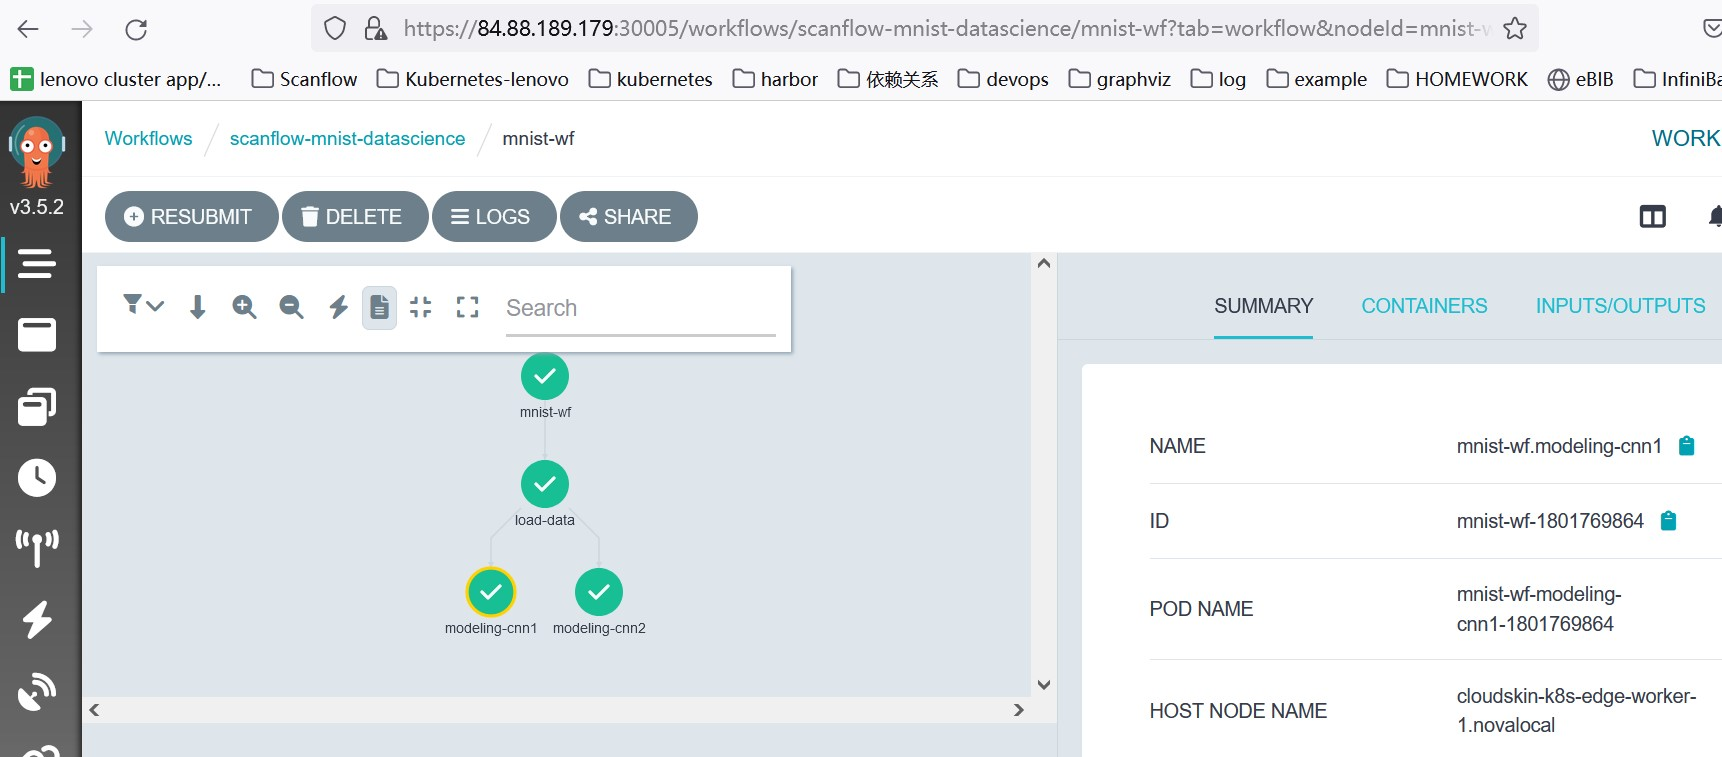

In [11]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/mnist-wf.jpg", width=1200, height=400)

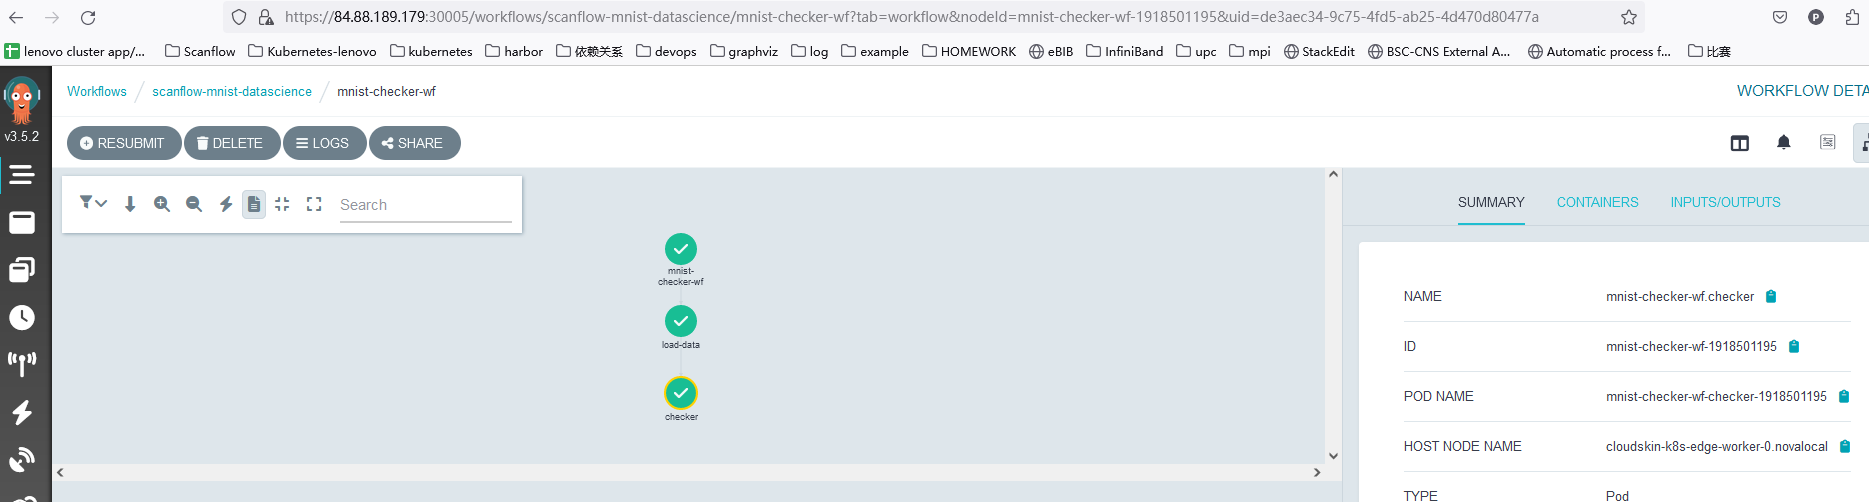

In [14]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/mnist-checker-wf.PNG", width=1400, height=400)

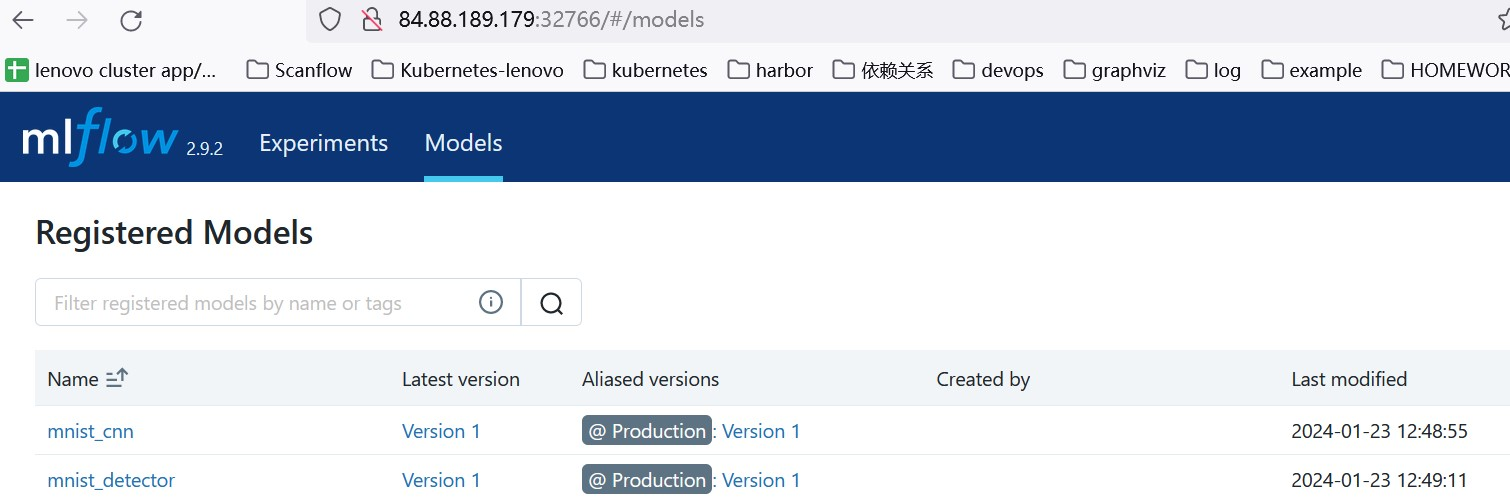

In [12]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/model-registry.jpg", width=1200, height=400)

### Step2-Step5: Debugging Tips

   1. If workflow failed due to an infrastructure layer problem, datascience team could click 'Resubmit' button to continue running executors starting from failure
   2. If datascience team want to change the parameters or structures of the workflow, datascience team should change the definition by repeating step2
   3. If datascience team want to change the executed script inside the executor, they should delete the original executor images from image registry and repeat step2-step3 to rebuild new images (It will be better team if could use local scanflow to debug their executor before deployment.)

### Step6: Submit the metadata, models and artifacts to the central Scanflow-tracker

  #### 6.1. Submit scanflowapp metadata
  ```bash
   mnist
    - datascience
     - workflows
        - mnist-check-wf.json
        - mnist-wf.json
     - mnist.json
  ```

In [8]:
trackerClient = ScanflowTrackerClient(
                        scanflow_tracker_local_uri="http://84.88.189.179:31000",
                        verbose=False)

In [18]:
trackerClient.save_app_meta(build_app)

#### 6.2. Submit prepared production model 

  1. change the prepared model into the 'production' stage (see figure below)
  2. submit mnist-checker model (e.g., mnist_detector)
  3. submit mnist model (e.g., mnist_cnn)

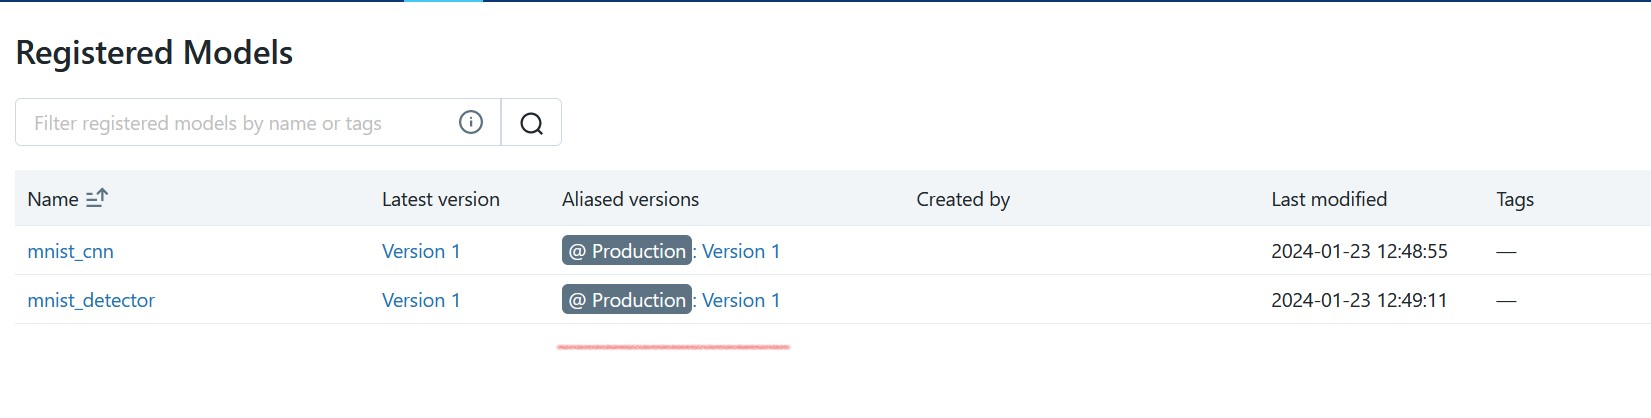

In [14]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/prepare-model.jpg", width=1200, height=400)

In [9]:
trackerClient.save_app_model(app_name=app_name,
                            team_name=team_name,
                            model_name="mnist_cnn",
                            model_version="1")

23-Jan-24 12:49:34 -  INFO - Found credentials in environment variables.
/home/rocky/local_resources/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024/01/23 12:49:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mnist_cnn, version 1


In [10]:
trackerClient.save_app_model(app_name=app_name,
                            team_name=team_name,
                            model_name="mnist_detector",
                            model_version="1")

2024/01/23 12:50:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: mnist_detector, version 1


In [11]:
# trackerClient.save_app_model(app_name=app_name,
#                             team_name=team_name,
#                             model_name="mnist-tf")

#### 6.3. Submit artifacts 

  ```bash
  mnist
    - workflows
       - load_data
         - loaddata.py
       - modeling_cnn1
         - modeling.py
         - req_modeling.txt
       - modeling_cnn2
         - modeling.py
         - req_modeling.txt
       - checker
         - checker.py
         - req_checker.txt
```


In [11]:
trackerClient.save_app_artifacts(app_name=app_name, 
                                team_name=team_name, 
                                app_dir=app_dir)

apiVersion: argoproj.io/v1alpha1
kind: Workflow
metadata:
  generateName: frozen runpy-
spec:
  affinity: {}
  entrypoint: frozen runpy
  templates:
    - name: frozen runpy
      steps: {}




  
### Step7: Clean scanflow environment
   1. clean environment

In [9]:
await deployerClient.clean_environment(app=build_app)

10-Jan-24 15:58:45 -  INFO - [++] Stopping tracker: [scanflow-tracker].
10-Jan-24 15:58:45 -  INFO - delete_deployment true
10-Jan-24 15:58:45 -  INFO - delete_service true
10-Jan-24 15:58:45 -  INFO - [++]Delete tracker configmap scanflow-tracker-env
10-Jan-24 15:58:45 -  INFO - delete_configmap true
10-Jan-24 15:58:45 -  INFO - [++]Delete client configmap scanflow-client-env
10-Jan-24 15:58:46 -  INFO - delete_configmap true
10-Jan-24 15:58:46 -  INFO - [++]Delete s3 secret scanflow-secret
10-Jan-24 15:58:46 -  INFO - delete_secret true
10-Jan-24 15:58:46 -  INFO - [++]Delete rolebinding default-admin
10-Jan-24 15:58:46 -  INFO - delete_rolebinding info
10-Jan-24 15:58:46 -  INFO - [++]Delete namespace "scanflow-mnist-datascience"
10-Jan-24 15:58:46 -  INFO - delete_namespace true
10-Jan-24 15:58:46 -  INFO - delete_pvc true
10-Jan-24 15:58:46 -  INFO - delete_pv true


True

apiVersion: argoproj.io/v1alpha1
kind: Workflow
metadata:
  generateName: frozen runpy-
spec:
  affinity: {}
  entrypoint: frozen runpy
  templates:
    - name: frozen runpy
      steps: {}



## Deliverables

After steps, you could check the deliverable from the central Scanflow-tracker http://172.30.0.50:46667.


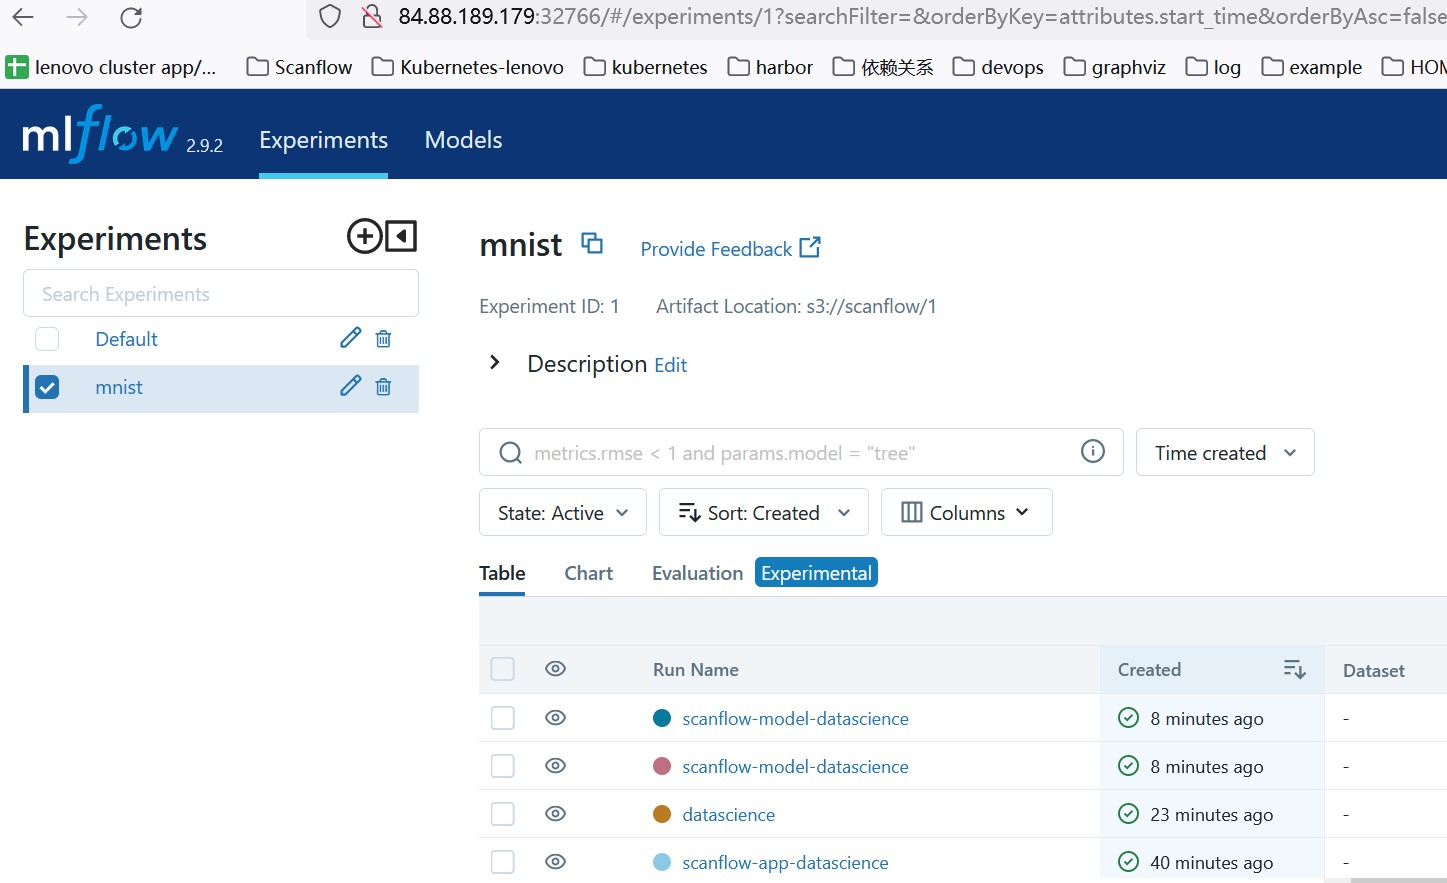

In [19]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/datascience-d.jpg", width=1200, height=400)

### Deliverable1: DataScienceTeam built scanflow application metadata

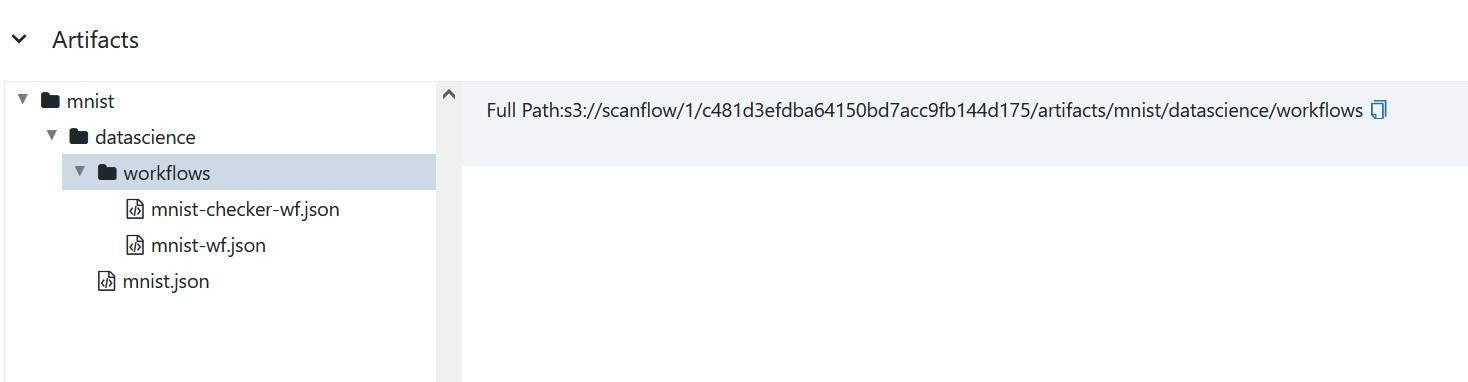

In [17]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/datascience-d1.jpg", width=1200, height=400)

### Deliverable2: DataScienceTeam machine learning models

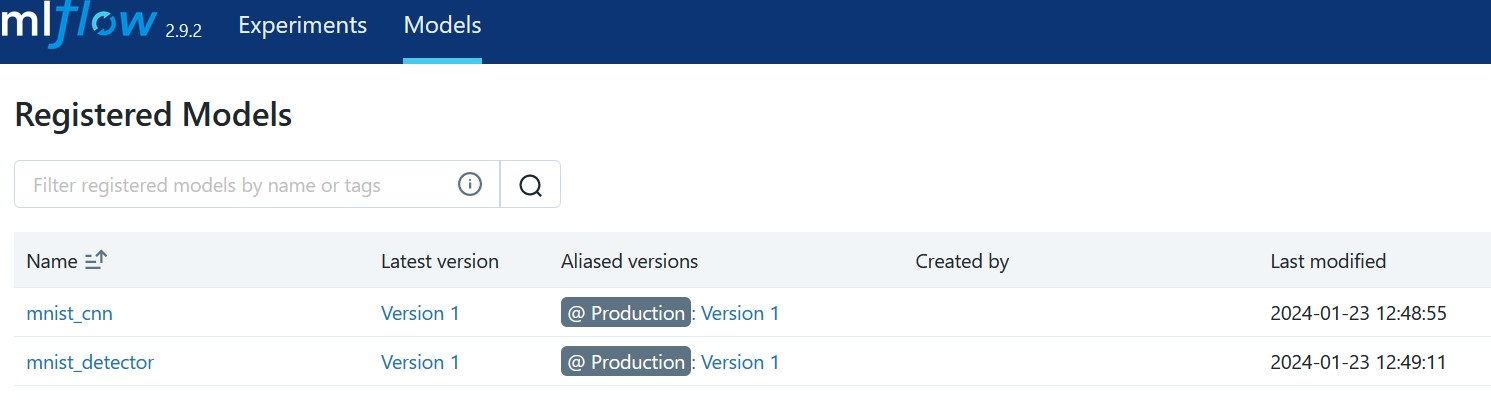

In [16]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/datascience-d2.jpg", width=1200, height=400)

### Deliverable3: DataScienceTeam artifacts

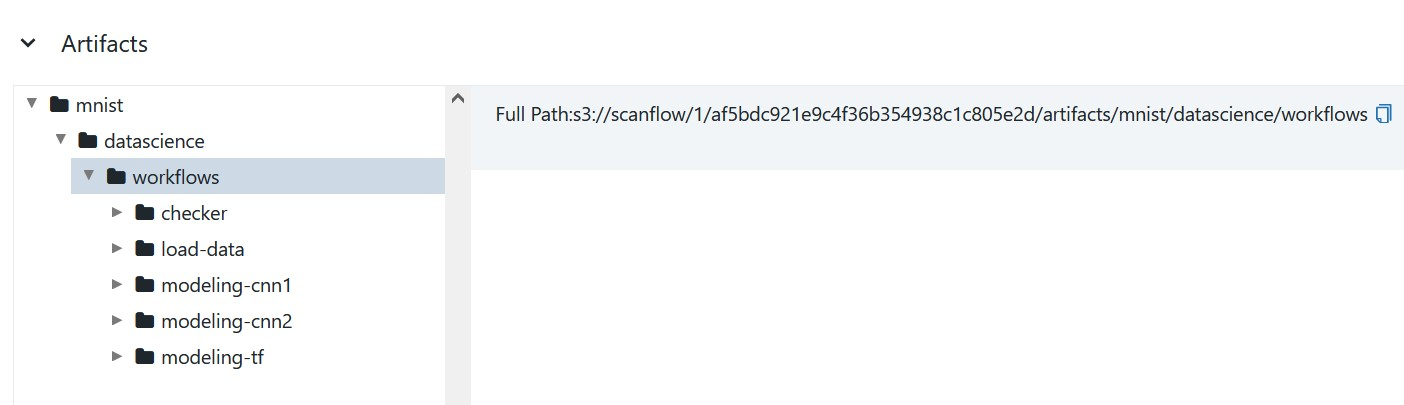

In [15]:
from IPython.display import Image
Image("/home/rocky/k8s_resources/scanflow/images/cloudskin/datascience-d3.jpg", width=1200, height=400)